In [79]:
import os, sys
import numpy as np
import pandas as pd
import EMdata
import torch
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time

In [80]:
#GPU or CPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 

In [125]:
#data path
file_path='F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select.star'
datatype=0 #0 is relion 3.1, 1 is relion 3
df=True
block_size=64
file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [126]:
%%time
if df:
    file_info=EMdata.read_data_df(file_path)
    dataframe=file_info.star2dataframe()
    metadata=dataframe.columns
    corpus_information=EMdata.process_helical_df(dataframe).extract_helical_select()
else:
    if datatype<2:
        file_info=EMdata.read_relion(file_path)
        if datatype==0:
            #read data (relion3.1)
            dataset=file_info.getRdata_31()
            optics=file_info.extractoptic()
        else:
            #read relion 3.0
            dataset=file_info.getRdata()
        metadata=dataset[0]
        print(metadata)
        data=dataset[1]
        print(data[0])
        #corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
        #label_path='F:/script/class2vec/real_star_file/self_unsupervised/10230_485_ctf/custom_single/pretext/'
        #label=np.load(label_path+'/classes_KM.npy')
        corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
corpus_dic,helix_name=corpus_information
corpus=list(corpus_dic.values())
print(corpus[0])
corpus_backup=corpus[:]

The filament number are:  3762
The number of particles are: 78025
0 636.2671130736669 mins
10000 636.290718960762 mins
20000 636.3140461921691 mins
30000 636.3378677845001 mins
40000 636.360948129495 mins
50000 636.3845146179199 mins
60000 636.4082333723704 mins
70000 636.4317505677541 mins
finish converting
[(15,  1, 16723) (42,  2, 46368) (10,  3, 10461) (79,  4, 40291)
 (15,  5, 16724) ( 1,  6, 68683) ( 1,  7, 68684) (29,  8, 50207)
 (74,  9, 35797) (30, 10, 64867) (30, 11, 64868) (30, 12, 64869)
 (41, 13, 59227) ( 8, 14, 22778) ( 8, 15, 22779) (36, 16, 25675)
 (36, 17, 25676) ( 2, 18,     8) (36, 19, 25677) (36, 20, 25678)
 (36, 21, 25679) ( 2, 22,     9) ( 2, 23,    10) (71, 24, 33397)
 (40, 25,  3716) (40, 26,  3717) (40, 27,  3718) (40, 28,  3719)
 (69, 29, 52072) (69, 30, 52073) (69, 31, 52074) (13, 32, 66213)
 (13, 33, 66214) (13, 34, 66215) (64, 35,  7285) (53, 36, 38136)
 (53, 37, 38137) (33, 38, 44480)]
[( 5,  4, 75477) (13,  5, 66216) (10,  6, 10462) (10,  7, 10463)
 (71, 

In [127]:
# cryosparc
#corpus_ignore=corpus

In [128]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    count=1
    lst=corpus[i]
    for j in range(len(lst)):
        particle=lst[j]
        if j==0:
            count+=particle[1]-1
        if count==int(particle[1]):
            corpus_row.append(str(particle[0]))
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(str(particle[0]))
                    count+=1
                    break
                corpus_row+=['0']
                count+=1               
    corpus_ignore.append(corpus_row)

In [129]:
#corpus_ignore=corpus
print(corpus_ignore[0])

['15', '42', '10', '79', '15', '1', '1', '29', '74', '30', '30', '30', '41', '8', '8', '36', '36', '2', '36', '36', '36', '2', '2', '71', '40', '40', '40', '40', '69', '69', '69', '13', '13', '13', '64', '53', '53', '33']


80


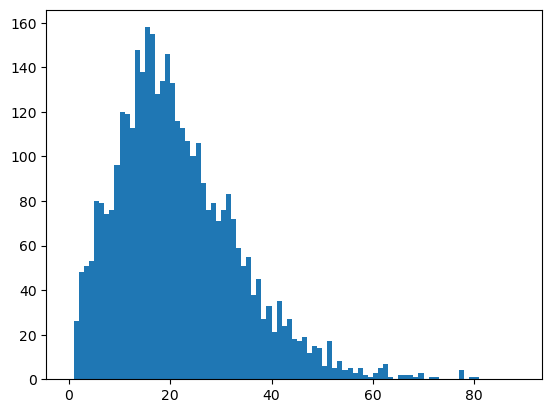

In [130]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
plt.hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,1)))
#plt.ylim((0,1000))
print(max(corpus_length_histogram))
plt.show()

In [131]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

43


In [132]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [133]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer
if os.path.isdir(output_path+"/corpus") is False:
    os.mkdir(output_path+"/corpus")
paths = [str(x) for x in Path(output_path+"/corpus/").glob("**/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=vocabulary_size, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])
if os.path.isdir(output_path+"/tokens") is False:
    os.mkdir(output_path+"/tokens")
if os.path.isdir("./tokens") is False:
    os.mkdir("./tokens")
tokenizer.save_model(output_path+"/tokens")
tokenizer.save_model("./tokens")

['./tokens\\vocab.json', './tokens\\merges.txt']

In [134]:
import json

with open(output_path+'/tokens/vocab.json') as f:
    decode = json.load(f)
encode={value:key for (key, value) in decode.items()}


In [135]:
corpus_code=[]
corpus_code_convert=[]
for i in range(len(corpus_ignore)):
    lst=corpus_ignore[i]
    corpus_row=[]
    for j in range(len(lst)):
        corpus_row.append(encode[word_to_index[lst[j]]+5])
    corpus_code.append(corpus_row)
    corpus_code_convert.append(corpus_row)
    corpus_code_convert.append(corpus_row[::-1])

In [136]:
lst[j]

'71'

In [137]:
with open(output_path+"/corpus/helical.txt","w") as f:
    for i in range(len(corpus_code)):
        lst=corpus_code[i]
        for j in range(len(lst)):
            if j==len(lst)-1:
                f.write(lst[j]+'\n')
            else:
                f.write(lst[j])

In [138]:
if '0' in [i for i in vocabulary]:
    del decode[encode[word_to_index['0']+5]]
    print('delete the ignored group',print(encode[word_to_index['0']+5]))
with open('./tokens/vocab.json','w') as f:
    json.dump(decode,f)
with open(output_path+'/tokens/vocab.json','w') as f:
    json.dump(decode,f)

J
delete the ignored group None


In [139]:
from transformers import RobertaTokenizerFast, BartTokenizer

tokenizer = BartTokenizer.from_pretrained(output_path+"/tokens", max_len=514)
#tokenizer.encode(encode[word_to_index['0']+5])

Didn't find file F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/tokens\added_tokens.json. We won't load it.
Didn't find file F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/tokens\special_tokens_map.json. We won't load it.
Didn't find file F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/tokens\tokenizer_config.json. We won't load it.
loading file F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/tokens\vocab.json
loading file F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/tokens\merges.txt
loading file None
loading file None
loading file None


In [140]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=50_000,
    max_position_embeddings=128,
    num_attention_heads=12,
    num_hidden_layers=12,
    type_vocab_size=1,
    position_embedding_type=None
)

In [141]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [142]:
%%time
from transformers import LineByLineTextDataset

data_import = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=output_path+"/corpus/helical.txt",
    block_size=block_size,
)

D:\ProgramData\Anaconda3\lib\site-packages\transformers\data\datasets\language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,
Creating features from dataset file at F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/corpus/helical.txt


Wall time: 510 ms


In [143]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [144]:
from transformers import Trainer, TrainingArguments


trainer = Trainer(
    model=model,
    data_collator=data_collator,
    train_dataset=data_import
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [145]:
trainer.train()

D:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3762
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1413


Step,Training Loss
500,4.276700
1000,2.936100


Saving model checkpoint to tmp_trainer\checkpoint-500
Configuration saved in tmp_trainer\checkpoint-500\config.json
Model weights saved in tmp_trainer\checkpoint-500\pytorch_model.bin
Saving model checkpoint to tmp_trainer\checkpoint-1000
Configuration saved in tmp_trainer\checkpoint-1000\config.json
Model weights saved in tmp_trainer\checkpoint-1000\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1413, training_loss=3.3606257671510087, metrics={'train_runtime': 120.2169, 'train_samples_per_second': 93.88, 'train_steps_per_second': 11.754, 'total_flos': 244484418653568.0, 'train_loss': 3.3606257671510087, 'epoch': 3.0})

In [146]:
trainer.save_model(output_path+"/tokens/")
trainer.save_model("./tokens/")

Saving model checkpoint to F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/tokens/
Configuration saved in F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/tokens/config.json
Model weights saved in F:/script/class2vec/real_star_file/10340_case2/10340_case2_600_t2_s0.5_job058_select/tokens/pytorch_model.bin
Saving model checkpoint to ./tokens/
Configuration saved in ./tokens/config.json
Model weights saved in ./tokens/pytorch_model.bin


In [147]:
from transformers import pipeline

feature_extraction = pipeline(
    'feature-extraction',model="./tokens",tokenizer="./tokens")

loading configuration file ./tokens\config.json
Model config RobertaConfig {
  "_name_or_path": "./tokens",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": null,
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50000
}

loading configuration file ./tokens\config.json
Model config RobertaConfig {
  "_name_or_path": "./tokens",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_

In [148]:
#print(np.shape(feature_extraction(encode[word_to_index['50']+5])))
#print(np.squeeze(feature_extraction('DGG'))[0]-np.squeeze(feature_extraction('JJ'))[0])
print(len(''.join(corpus_code[2])))
print(len(corpus_ignore[2]))

24
24


In [149]:
def cut_corpus(corpus,cut_length):
    cut_index=[]
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<=cut_length:
            new_corpus.append(lst)
            continue
        if n%cut_length==0:
            cut_amount=int(n/cut_length)
        else:
            cut_amount=int((n-n%cut_length)/cut_length)+1
        for j in range(cut_amount-1):
            cut_index.append(i)
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus,cut_index
corpus_code_cut,cut_index=cut_corpus(corpus_code,block_size-2)

3762
3781


In [150]:
filament_embeddings=[]
for i in range(len(corpus_code_cut)):
    if i%200==0:
        print(i)
    lst=list((np.squeeze(feature_extraction(''.join(corpus_code_cut[i])))[0]))
    filament_embeddings.append(lst)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600


In [151]:
import umap
import sklearn
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [152]:
filament_embeddings=np.array(filament_embeddings)
mask_1 = np.isfinite(filament_embeddings).all(axis=1)

In [153]:
len(filament_embeddings[mask_1])

3781

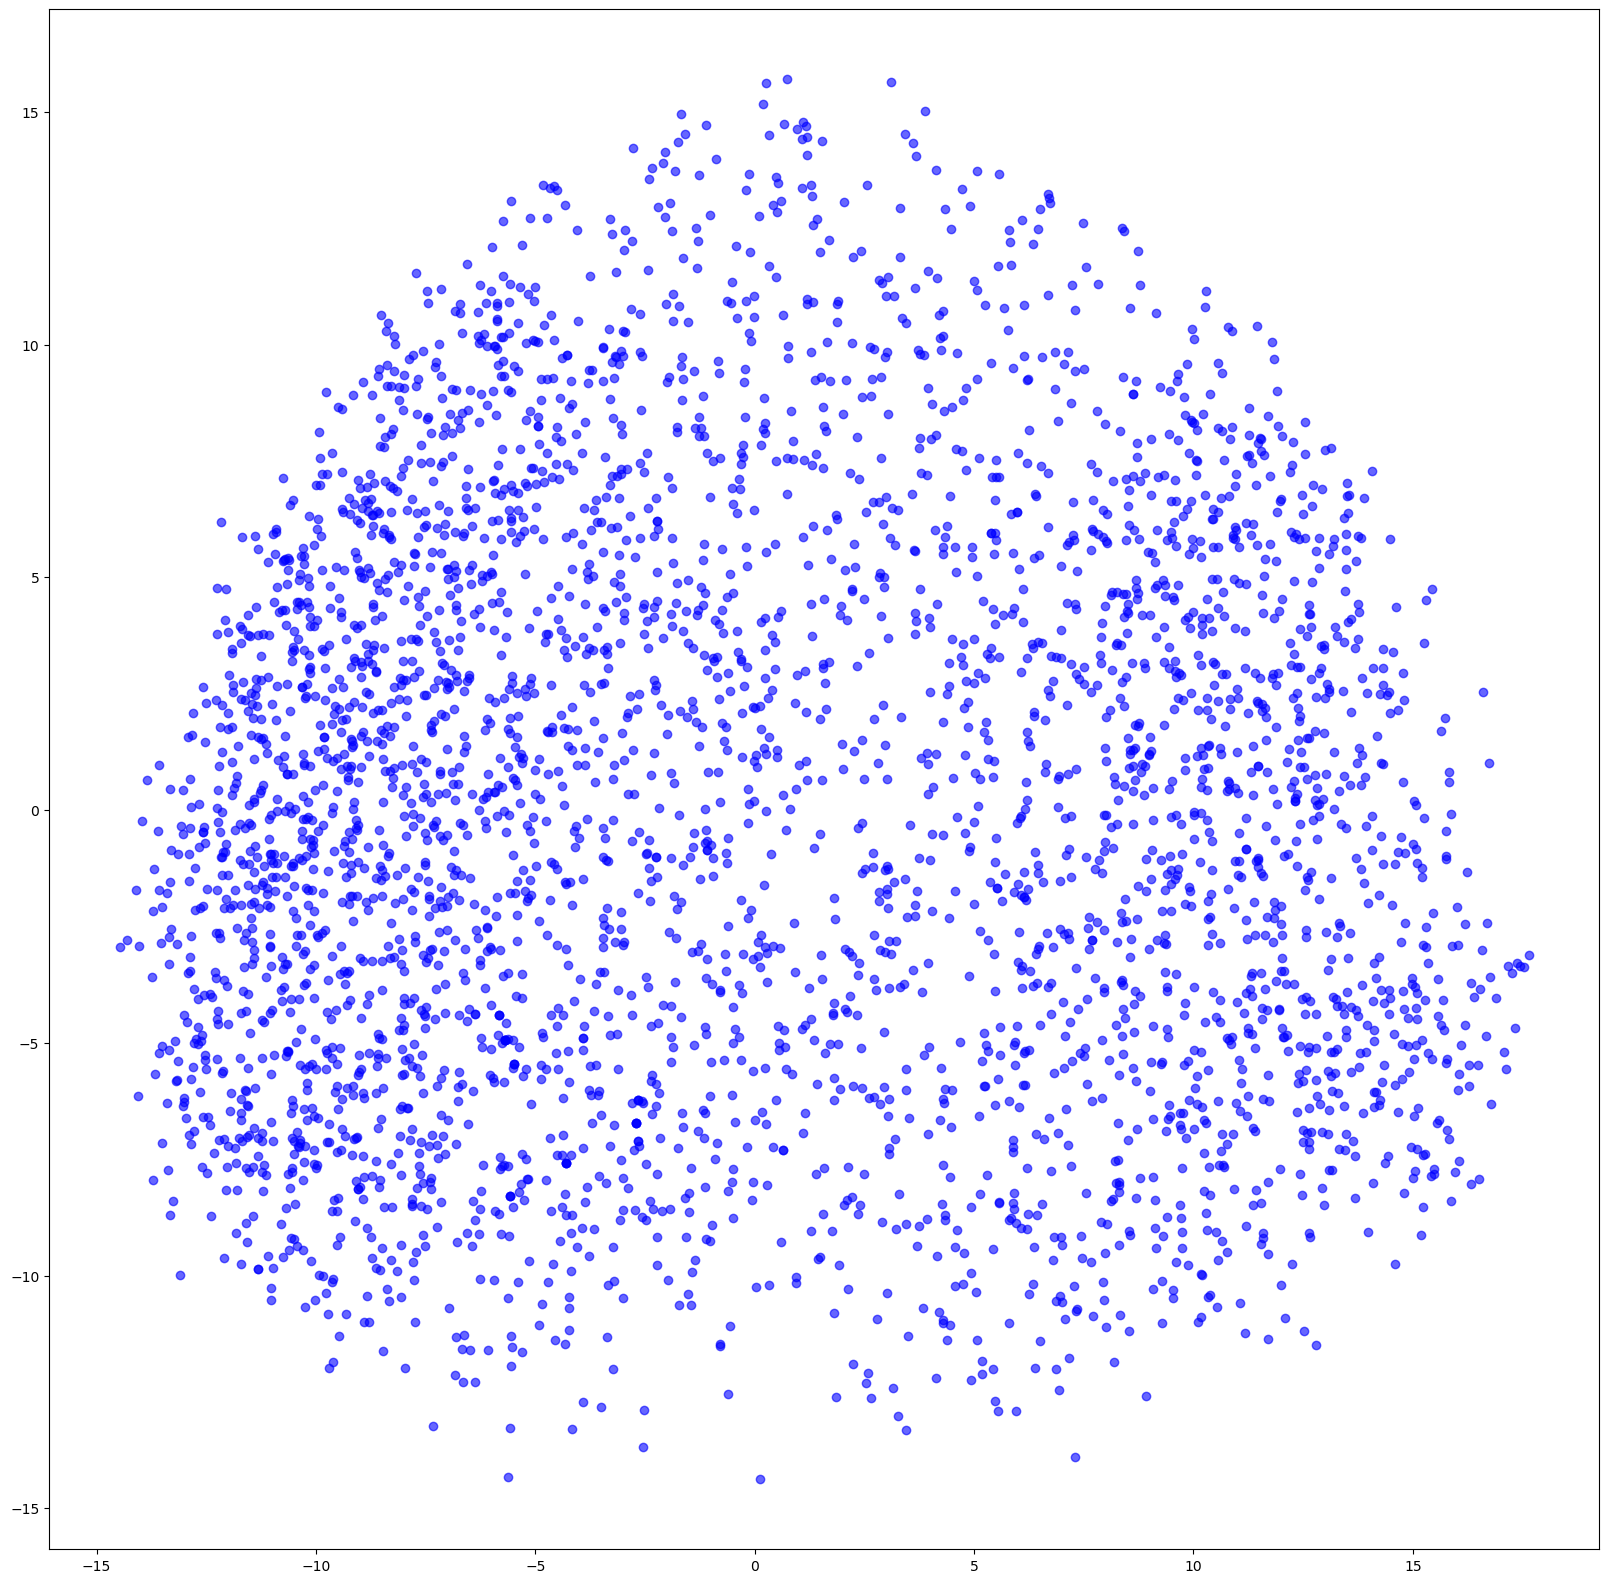

In [154]:
pca_sum = PCA(n_components=2).fit_transform(filament_embeddings)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])
pca_sum_hD = PCA(n_components=30).fit_transform(filament_embeddings)

plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:,0], pca_sum[:,1],alpha=0.6,color='blue')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [200]:
%%time
n_neighbors=50
min_dist=0.1
#umap_ND=umap.UMAP(n_neighbors=200,min_dist=0.4,n_components=100).fit_transform(filament_embeddings)
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(filament_embeddings)
umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=100).fit_transform(filament_embeddings)
print('finish umap')

finish umap
Wall time: 39 s


1


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  f"KMeans is known to have a memory leak on Windows "


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


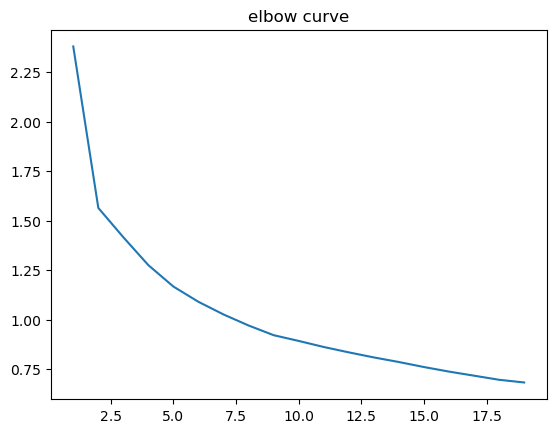

In [201]:
res = []
n_cluster = range(1,20)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(umap_ND)
    res.append(np.average(np.min(cdist(umap_ND, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

2
3
4
5
6
7
[0.4599629, 0.32810625, 0.24623469, 0.25898018, 0.24421562, 0.24131374]


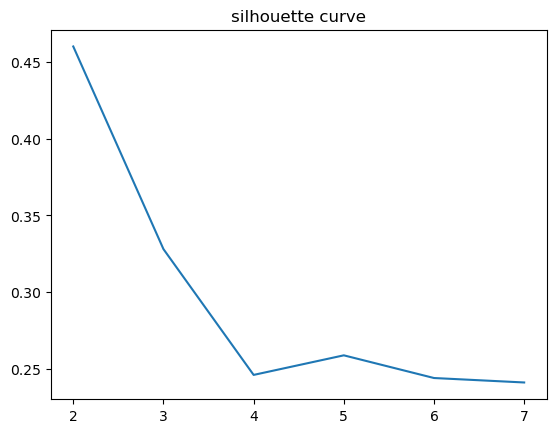

In [202]:
res=[]
n_cluster = range(2,8)
for i in n_cluster:
    print(i)
    kmeans_model = KMeans(n_clusters=i).fit(umap_2D)
    labels = kmeans_model.labels_
    a=metrics.silhouette_score(umap_ND, labels, metric='euclidean')
    res.append(a)

plt.plot(n_cluster, res)
print(res)
plt.title('silhouette curve')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_silhouette.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [223]:
filament_cluster_number=res.index(max(res[1:]))+2
filament_cluster_number=2
#print(filament_cluster_number)
umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(umap_ND)
#umap_predict=SpectralClustering(n_clusters=filament_cluster_number).fit_predict(umap_ND)
#umap_predict=DBSCAN(eps=1.6, min_samples=280).fit_predict(umap_2D)+1
#filament_cluster_number=len(np.unique(umap_predict))
print(filament_cluster_number)

2


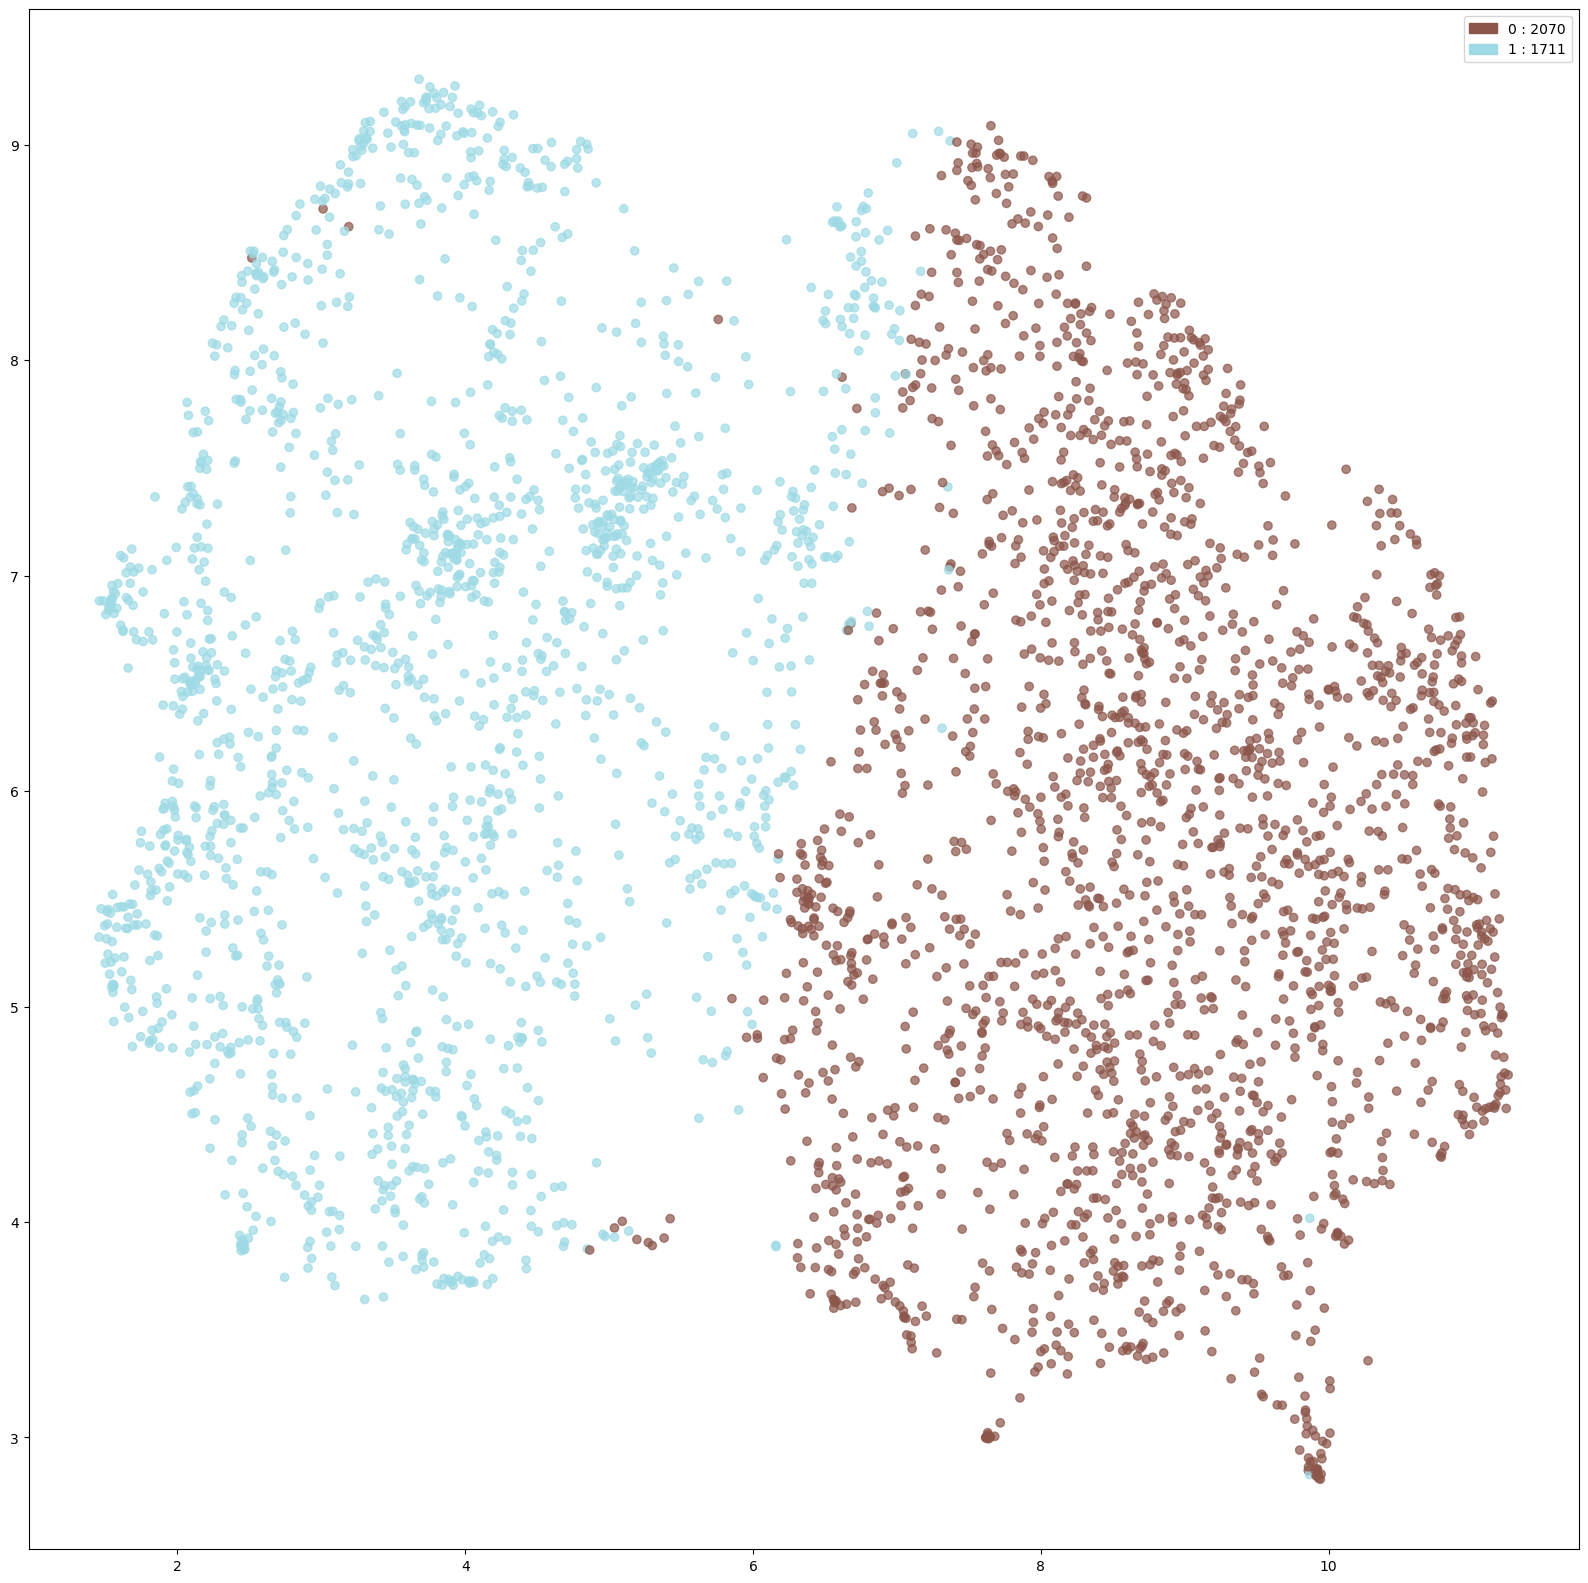

In [224]:
plt.figure(figsize = (20, 20))

for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), 
                                             label=str(i)+' : '+str(np.count_nonzero(umap_predict==i)))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
#plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.6,c=plt.cm.tab20((umap_predict)/filament_cluster_number))
plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.7,c=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
#plt.xlim((-5,10))
#plt.ylim((-10,6))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_np.png",bbox_inches='tight', pad_inches=0.01)
#c=plt.cm.tab20((umap_predict+1)/filament_cluster_number)
plt.show()

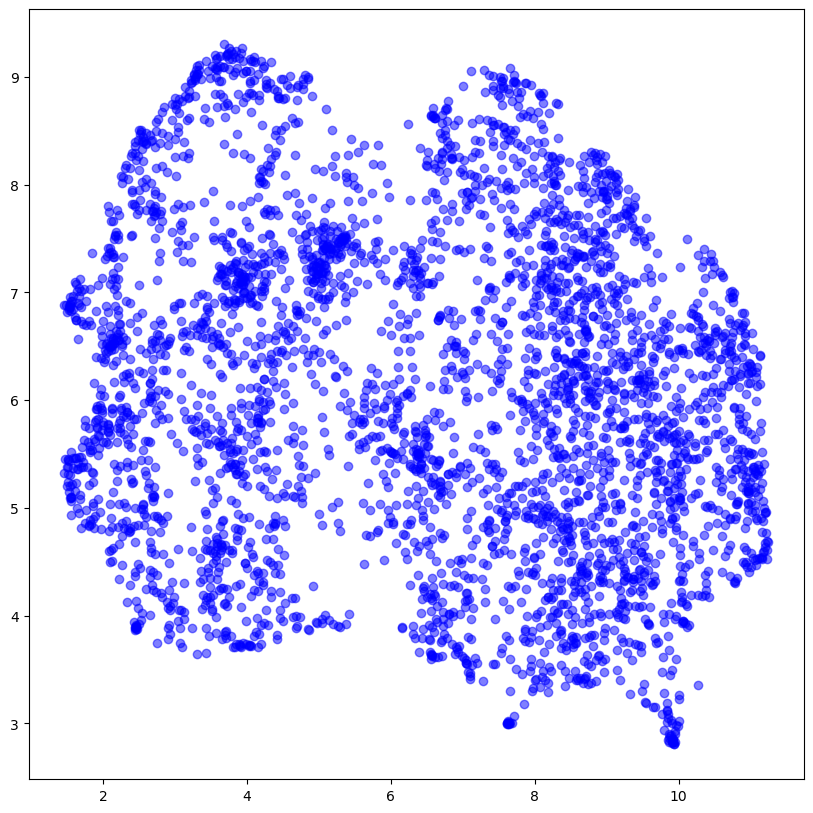

In [225]:
plt.figure(figsize = (10, 10))

#for i in range(filament_cluster_number):
#    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i)/filament_cluster_number), 
#                                             label=str(i)+' : '+str(np.count_nonzero(umap_predict==i)))
#plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
#plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.6,c=plt.cm.tab20((umap_predict)/filament_cluster_number))
plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.5,c='blue')
#plt.xlim((-5,4))
#plt.ylim((-7,10))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_blue.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
#c=plt.cm.tab20((umap_predict+1)/filament_cluster_number)

In [226]:
helix_name[i][0][11:]

'190/Case2/FoilHole_24943303_Data_24944186_24944187_20190125_1841-129200.mrcs'

In [227]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
start_index=11
#84
cluster_choice=umap_predict
positive_label=[]
cut_index=np.array(cut_index)
for i in range(len(helix_name)):
    if i in cut_index:
        t=np.count_nonzero(cut_index==i)
        while t>0:
            positive_label.append(helix_name[i][0][start_index:start_index+3])
            t-=1
    positive_label.append(helix_name[i][0][start_index:start_index+3])
positive_label=np.array(positive_label)
labels=list(np.unique(positive_label))
positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
#labels_name=['type 3','type 1B','type 2B','type 1A','type 2A','type 2AB'] # define the type of filaments 
labels_name=['singlet','doublet']
#labels_name=['1','2']
#labels_name=['1','2','3','4','5']
#labels_name=['SF','PHF']
#labels_name=[1,2,3]
#labels_name=['PHF','SF']
clustersize=[]
for i in range(filament_cluster_number):
    clustersize.append(len(locals()['cluster'+str(i)]))
print(positive_label_new[2])
print(labels)

0.0
['190', '408']


In [228]:
helix_name[0]

('Extract/job190/Case2/FoilHole_24943303_Data_24944182_24944183_20190125_1840-129199.mrcs',
 0)

In [229]:
np.count_nonzero(cut_index==126)

0

0
1
3781


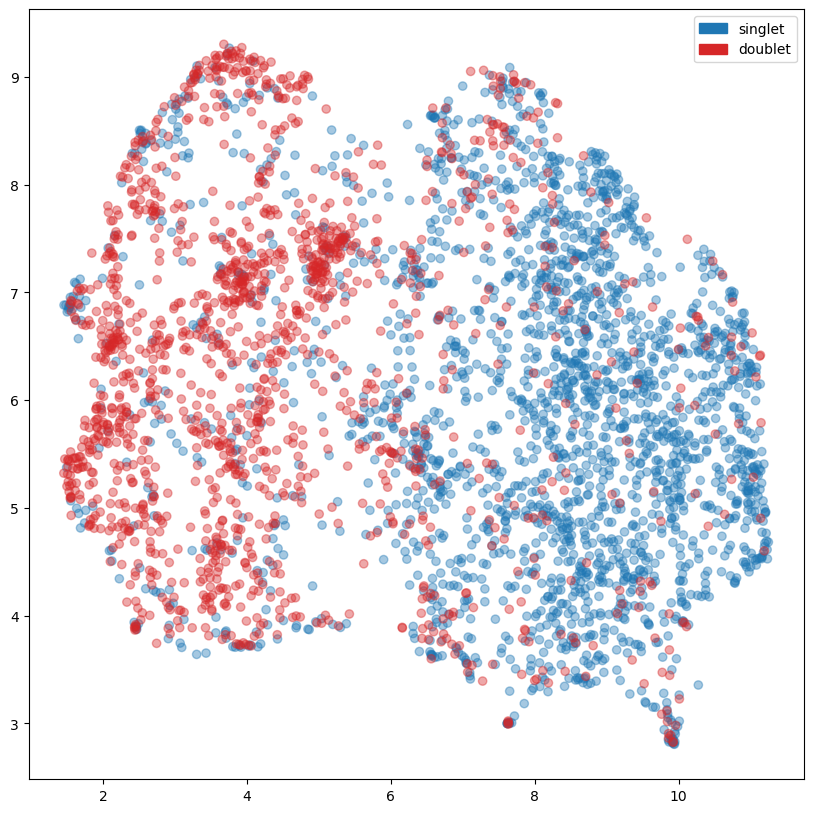

In [230]:
plt.figure(figsize = (10, 10))
for i in range(len(labels_name)):
    print(i)
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/3), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
#plt.xlim((8,16))
#plt.ylim((0,9))
plt.scatter(umap_2D[:,0], umap_2D[:,1],color=plt.cm.tab20(positive_label_new/3),alpha=0.4)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_label_bert.png",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_label_bert.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [231]:
print(len(positive_label_new),len(cluster_choice))
hist_data=pd.DataFrame({'labels':positive_label_new,'predict':cluster_choice})
distribution_hist_all=[]
print(hist_data)
print(labels)

3781 3781
      labels  predict
0        0.0        0
1        0.0        0
2        0.0        0
3        0.0        0
4        0.0        0
...      ...      ...
3776     1.0        1
3777     1.0        1
3778     1.0        0
3779     1.0        1
3780     1.0        1

[3781 rows x 2 columns]
['190', '408']


In [232]:
for i in range(0,filament_cluster_number):
    distribution=[]
    lst=hist_data[hist_data['predict']==i]
    for j in range(len(labels)):
        distribution.append(len(lst[lst['labels']==j])/len(lst))
    distribution_hist_all.append(distribution)
print(distribution_hist_all)

[[0.8695652173913043, 0.13043478260869565], [0.2682641729982466, 0.7317358270017533]]


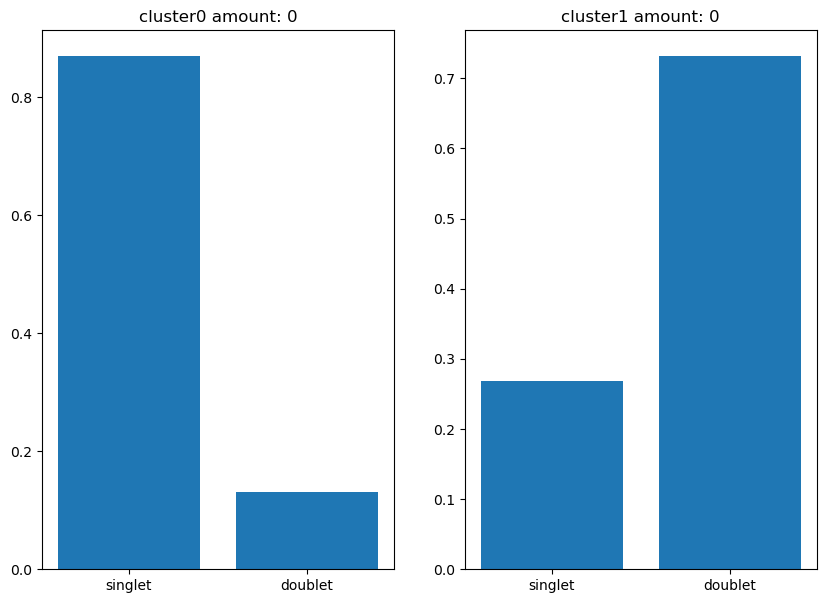

a


In [233]:
fig, ax = plt.subplots(1,filament_cluster_number,figsize = (5*filament_cluster_number,7))
for i in range(filament_cluster_number):
    ax[i].bar(range(len(labels)),distribution_hist_all[i],tick_label =labels_name)
    particle_number=len(locals()['cluster'+str(i)])
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))

plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new_bert.png')
plt.show()
print('a')

In [234]:
#fill corpus
corpus_fill=[]
for i in range(len(corpus)):
    corpus_row=[]
    count=1
    lst=corpus[i]
    for j in range(len(lst)):
        particle=lst[j]
        if j==0:
            count+=particle[1]-1
        if count==int(particle[1]):
            corpus_row.append(particle)
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(particle)
                    count+=1
                    break
                corpus_row+=[(0,count,0)]
                count+=1
    corpus_fill.append(corpus_row)
corpus_fill_cut,corpus_cut_index=cut_corpus(corpus_fill,block_size-2)

3762
3781


In [235]:
if df:
    dataframe_out=dataframe.drop(columns=['pid','filename','class','helicaltube','phi0'])
    metadata=list(dataframe_out.columns)
    metadata=['_'+name for name in metadata]
    data=dataframe_out.values
    optics=EMdata.read_relion(file_path).extractoptic()
for i in range(filament_cluster_number):
    locals()['cluster'+str(i)]=[]
    locals()['clusterID'+str(i)]=[]
#count=0    
for i in range(len(corpus_fill_cut)):
    labels=umap_predict[i]
    locals()['clusterID'+str(labels)].append(i)
    lst=corpus_fill_cut[i]
    for j in range(len(lst)):
        particle=lst[j]
        if particle[0]!=0:
            #count+=1
            dataline=particle[-1]
            locals()['cluster'+str(labels)].append(data[dataline])
number=0
for i in range(filament_cluster_number):
    cluster_number_count=len(locals()['cluster'+str(i)])
    print(i,cluster_number_count)
    number=number+cluster_number_count
print(number-len(data))

0 36686
1 41339
0


In [236]:
print(metadata)

['_rlnAnglePsi', '_rlnAnglePsiFlipRatio', '_rlnAnglePsiPrior', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAngleTiltPrior', '_rlnClassNumber', '_rlnCoordinateX', '_rlnCoordinateY', '_rlnCtfBfactor', '_rlnCtfFigureOfMerit', '_rlnCtfMaxResolution', '_rlnCtfScalefactor', '_rlnDefocusAngle', '_rlnDefocusU', '_rlnDefocusV', '_rlnGroupNumber', '_rlnHelicalTrackLengthAngst', '_rlnHelicalTubeID', '_rlnImageName', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnMicrographName', '_rlnNormCorrection', '_rlnNrOfSignificantSamples', '_rlnOpticsGroup', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnPhaseShift']


In [237]:
# for input label
#for i in range(filament_cluster_number):
#    locals()['cluster'+str(i)]=[]
#    locals()['clusterID'+str(i)]=[]
#for i in range(len(corpus)):
#    labels=umap_predict[i]
#    locals()['clusterID'+str(labels)].append(i)
#    lst=corpus[i]
#    for j in range(len(lst)):
#        dataline=i+j
#        locals()['cluster'+str(labels)].append(data[dataline])

In [238]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=EMdata.output_star(output_path+'/bert_'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()